In [280]:
import sys
sys.path.append('../code/functions/')
import tiffIO as io

import math
import cv2
import time
import pickle

import numpy as np
import synapseLib as sl
import matplotlib.pyplot as plt

from scipy.ndimage.filters import maximum_filter

from skimage.exposure import equalize_adapthist
from scipy.signal import convolve
from scipy.stats import linregress

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [41]:
data = np.array(io.loadTiff('../data/rr46b_s0_ch1.tif'))

In [5]:
def extractAxons(imgStack, n=2, neighborhood = 16, percentile=80, dilations=5):
    axonProxStack = []
    nthStack = []

    for img in imgStack:
        nthImg = nthAve(img, n, neighborhood, neighborhood)
        dil = cv2.dilate(nthImg, None, iterations=dilations)
        mask = dil > np.percentile(dil, percentile)

        axonProxImg = img * mask
        axonProxStack.append(axonProxImg)

        nthStack.append(nthImg)

    return np.stack(axonProxStack), np.stack(nthStack)


def nthAve(img, n, stepY, stepX):

    out = np.zeros_like(img)
    for yStart in range(0, img.shape[0], stepY):
        curRow = []
        for xStart in range(0, img.shape[1], stepX):
            sub = img[yStart:yStart+stepY, xStart:xStart+stepX]
            out[yStart:yStart+stepY, xStart:xStart+stepX] = np.average(sub)**n
    return np.stack(out)


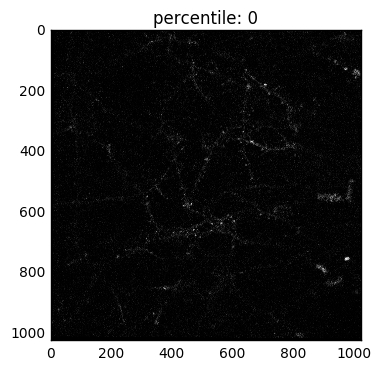

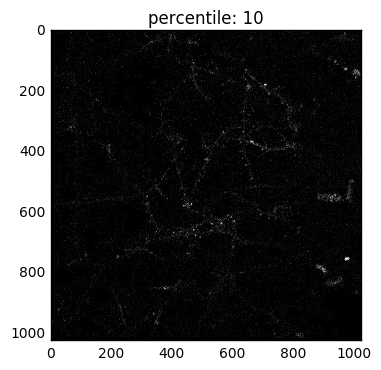

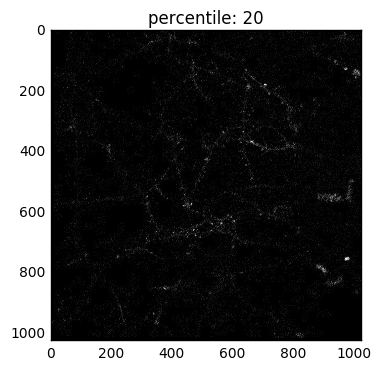

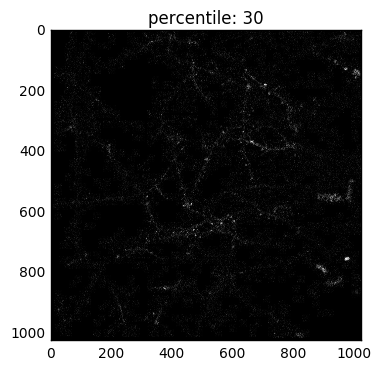

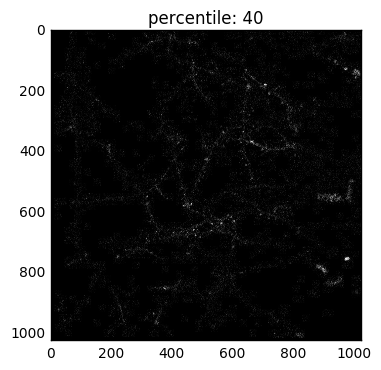

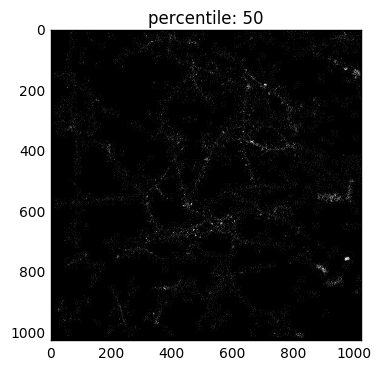

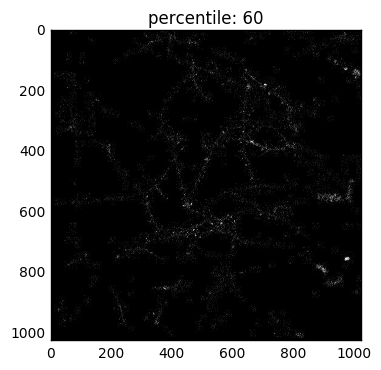

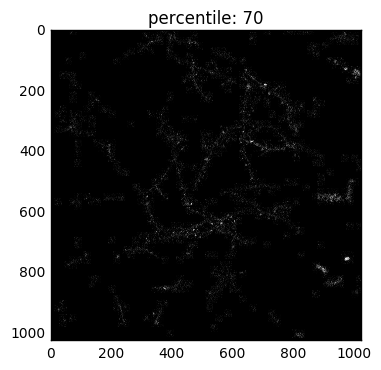

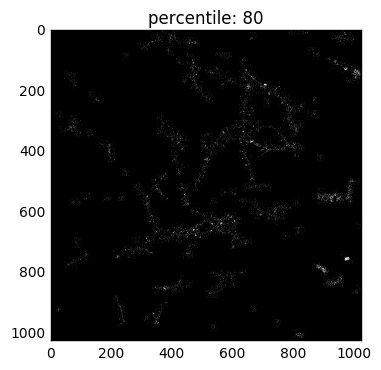

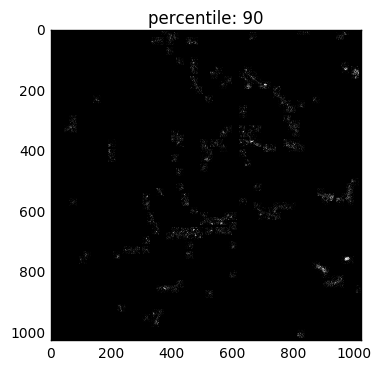

In [25]:
for i in range(0, 100, 10):
    res, _ = extractAxons(data, percentile = i)
    plt.title("percentile: " + str(i))
    plt.imshow(res[15], cmap='gray')
    plt.show()

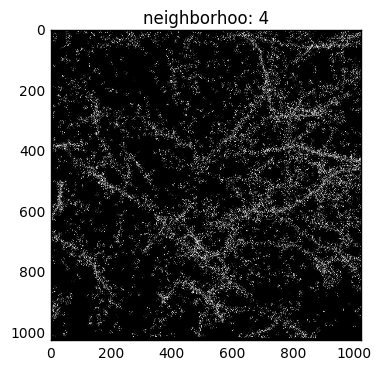

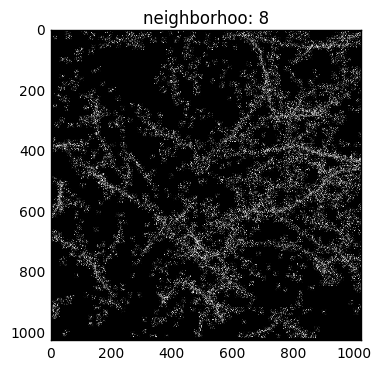

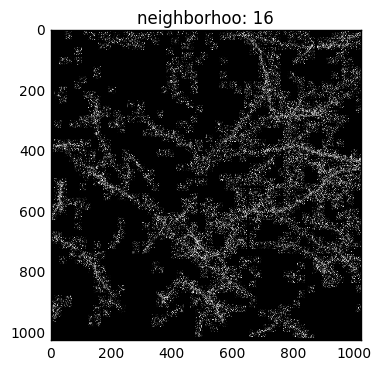

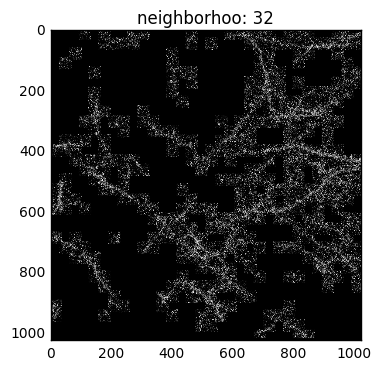

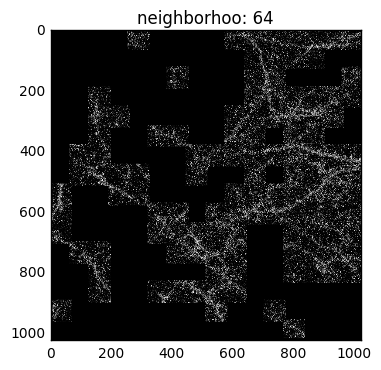

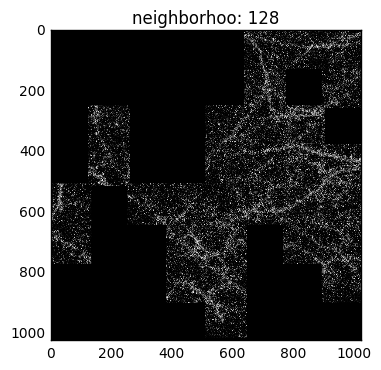

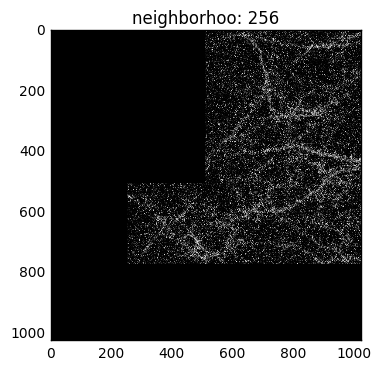

In [21]:
for i in range(2, 9, 1):
    res, _ = extractAxons(data, neighborhood = 2**i, percentile = 50)
    plt.title("neighborhoo: " + str(2**i))
    plt.imshow(np.power(res[20], 2), cmap='gray')
    plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: RuntimeWarning:

invalid value encountered in power



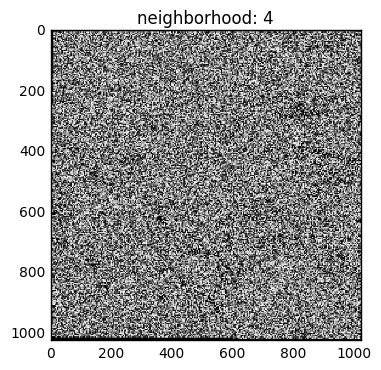

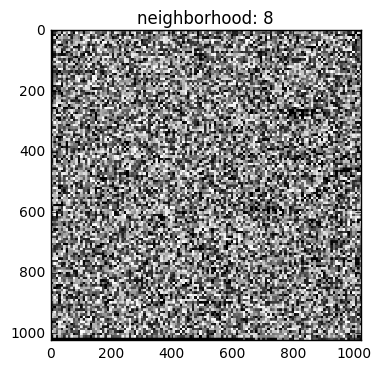

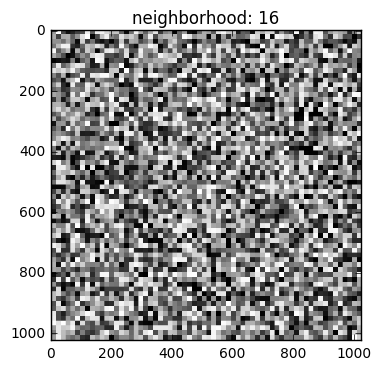

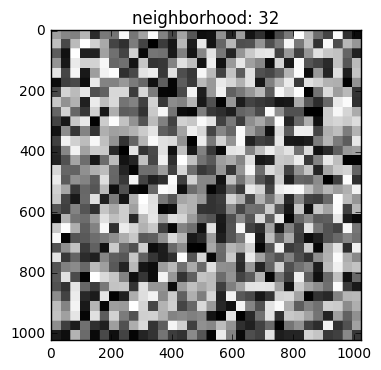

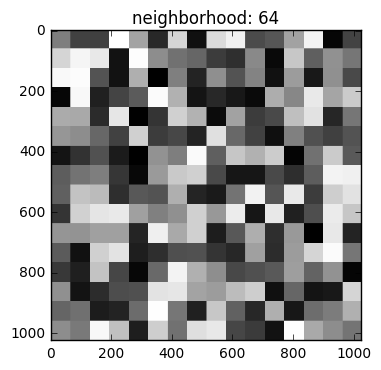

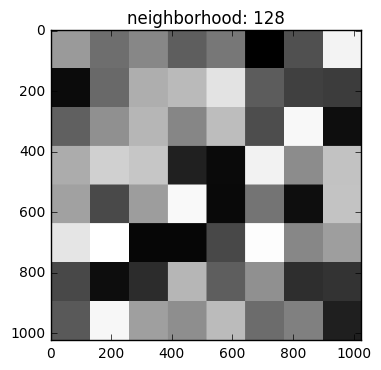

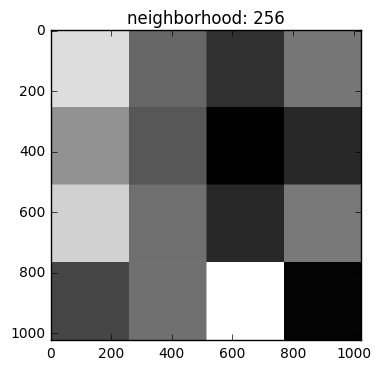

In [23]:
for i in range(2, 9, 1):
    res, dat = extractAxons(data, neighborhood = 2**i, percentile = 50)
    plt.title("neighborhood: " + str(2**i))
    plt.imshow(np.power(dat[20], 2), cmap='gray')
    plt.show()

In [ ]:
res, _ = extractAxons(data, percentile = i)
plt.title("percentile: " + str(i))
plt.imshow(np.power(res[15], 2), cmap='gray')
plt.show()

In [28]:
res, nth = extractAxons(data, neighborhood = 16, percentile = 50)

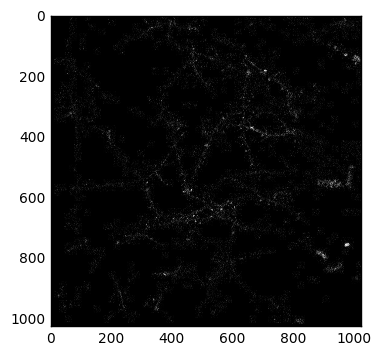

In [29]:
plt.figure()
plt.imshow(res[15], cmap='gray')
plt.show()

In [30]:
segment = sl.segmentAxons(res) 

Parallel took:  435.534188032


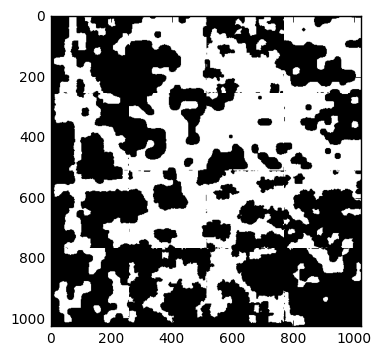

In [31]:
plt.imshow(segment[15], cmap='gray')
plt.show()

In [37]:
equStack = np.stack([equalize_adapthist(img) for img in res])

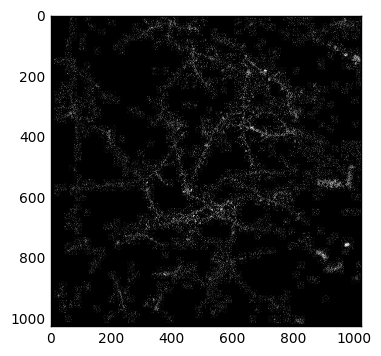

In [38]:
plt.figure()
plt.imshow(equStack[15], cmap='gray')
plt.show()

In [49]:
res, nth = extractAxons(np.stack([equalize_adapthist(elem) for elem in data]), neighborhood = 16, percentile = 50)

/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:110: UserWarning:

Possible precision loss when converting from float64 to uint16



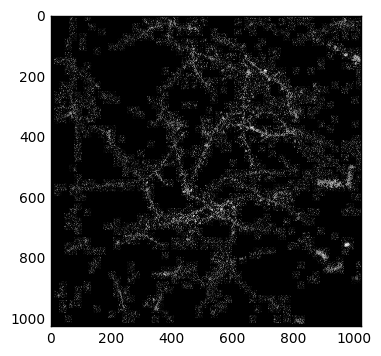

In [148]:
plt.figure()
plt.imshow(equalize_adapthist(res[15]), cmap='gray')
plt.show()

In [78]:
kernel = np.multiply(np.ones((4, 4)), 15)

In [79]:
roadmap = res[15]
for i in range(5):
    roadmap = convolve(roadmap, kernel)

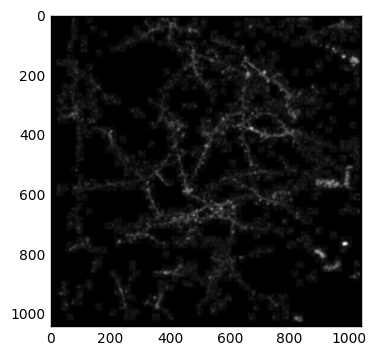

In [80]:
plt.figure()
plt.imshow(roadmap, cmap='gray')
plt.show()

In [118]:
fd, hog_image = hog(res[15], orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualise=True)

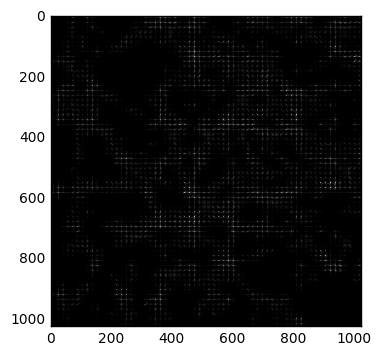

In [121]:
plt.figure()
plt.imshow(hog_image, cmap='gray')
plt.show()

In [212]:
regionMeans = []
regionMax = []
regionRatio = []
print hog_image.shape
for y in range(0, 1024, 64):
    for x in range(0, 1024, 64):
        sub = hog_image[y:y+64, x:x+64]
        regionMeans.append(np.mean(sub))
        regionMax.append(np.argmax(sub))
        regionRatio.append(np.count_nonzero(sub)/float(4096))

(1024, 1024)


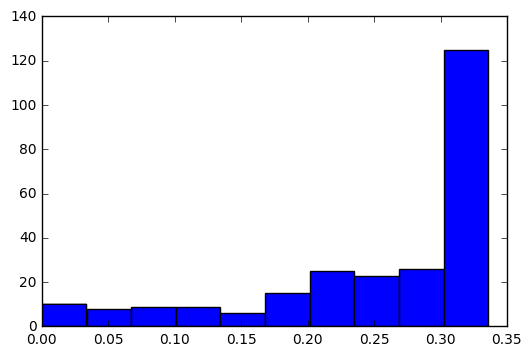

In [127]:
plt.hist(regionRatio)
plt.show()

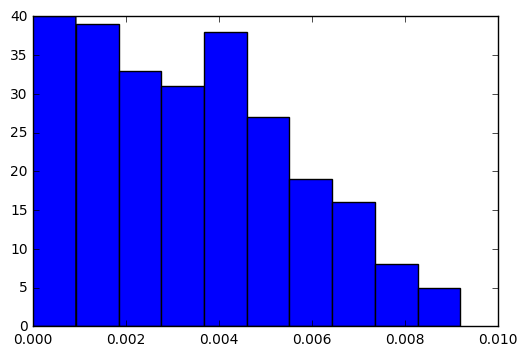

In [128]:
plt.hist(regionMeans)
plt.show()

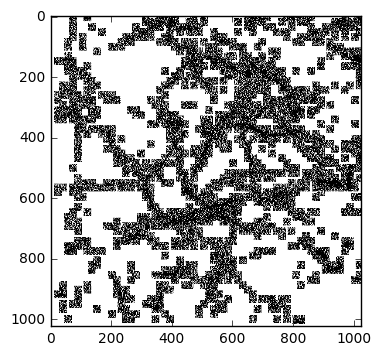

In [130]:
plt.figure()
cat = res[15] != 0
invCat = 1-cat
plt.imshow(invCat, cmap='gray')
plt.show()

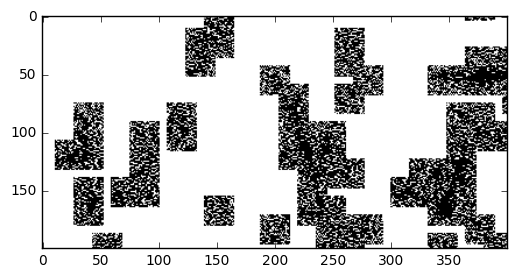

In [131]:
plt.imshow(invCat[800:1000,0:400], cmap='gray')
plt.show()

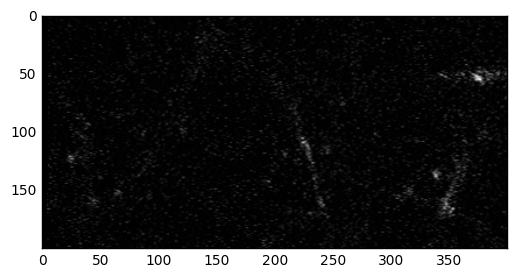

In [133]:
plt.imshow(data[15, 800:1000,0:400], cmap='gray')
plt.show()

In [155]:
blurred = blur = cv2.GaussianBlur(np.multiply(equalize_adapthist(res[15]),255), (5, 5), 0)

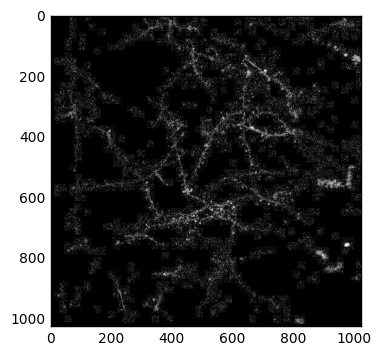

In [156]:
plt.imshow(blur, cmap='gray')
plt.show()

In [166]:
dil = cv2.dilate(blurred, None, iterations=5)

In [174]:
ero = cv2.erode(blurred, None, iterations=1)

In [175]:
magic = equalize_adapthist(np.divide(ero, float(np.max(ero))))

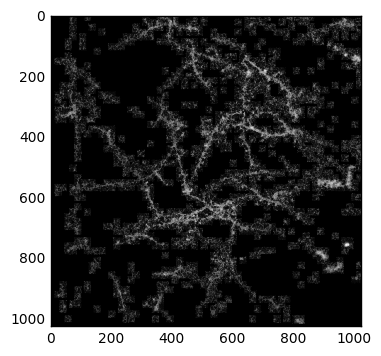

<type 'numpy.ndarray'>


In [208]:
plt.imshow(magic, cmap='gray')
plt.show()
print type(magic)

In [281]:
def sigmoid(x):
    return 1./(1.+math.exp(-x))

In [509]:
out = np.ones_like(magic)
i = 8
for y in range(0, 1024, i):
    for x in range(0, 1024, i):
        cutoff = i**2 * .5
        sub = magic[y:y+i, x:x+i]
        ave = np.average(sub)
        yList, xList = np.nonzero(sub)
        if len(xList) > cutoff and len(yList) > cutoff:
            _, _, r, _, _ = linregress (xList, yList)
            out[y:y+i, x:x+i] = r
        else:
            continue

np.stack(out)
        

array([[ 1.,  1.,  1., ...,  0.,  0.,  0.],
       [ 1.,  1.,  1., ...,  0.,  0.,  0.],
       [ 1.,  1.,  1., ...,  0.,  0.,  0.],
       ..., 
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.]])

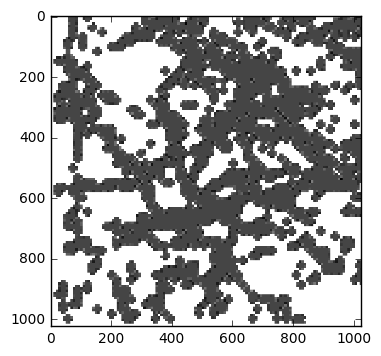

In [510]:
plt.figure()
plt.imshow(out, cmap='gray')
plt.show()

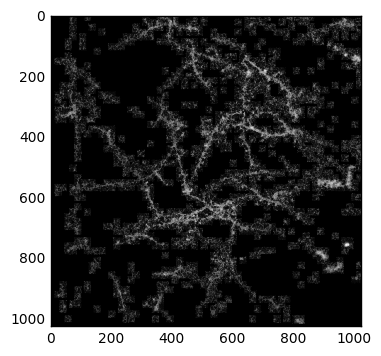

<type 'numpy.ndarray'>


In [511]:
plt.imshow(magic, cmap='gray')
plt.show()
print type(magic)

In [512]:
inv = np.abs(np.subtract(out, 1))

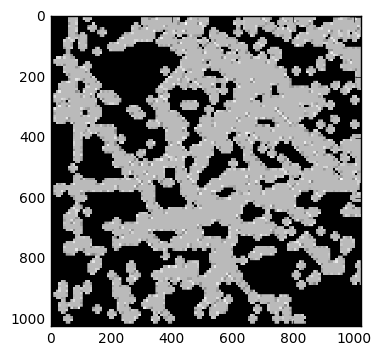

In [513]:
plt.imshow(inv, cmap='gray')
plt.show()


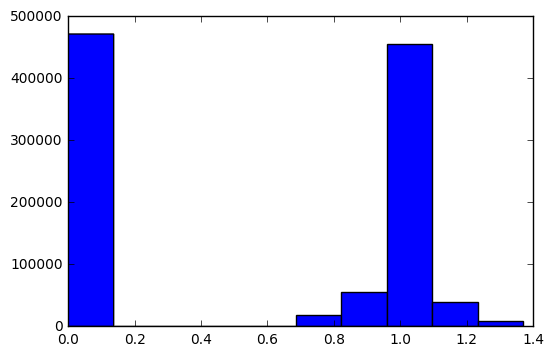

In [514]:
plt.hist(inv.flatten())
plt.show()


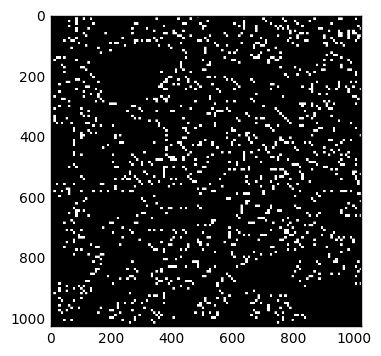

In [515]:
d = np.percentile(inv, 80)
dog = inv > d
plt.imshow(dog, cmap='gray')
plt.show()

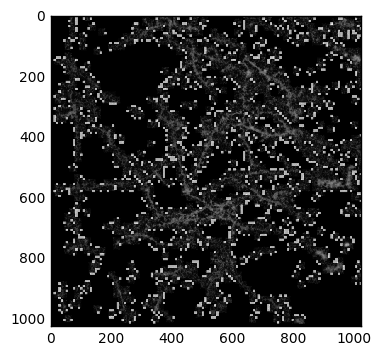

<type 'numpy.ndarray'>


In [516]:
plt.imshow(np.add(magic,dog), cmap='gray')
plt.show()
print type(magic)

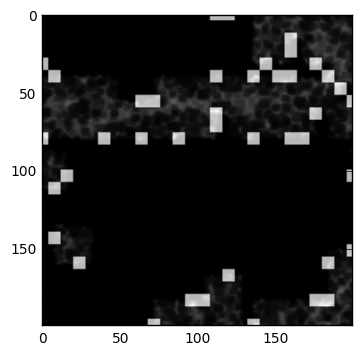

<type 'numpy.ndarray'>


In [517]:
plt.imshow(np.add(magic,dog)[500:700, 100:300], cmap='gray')
plt.show()
print type(magic)

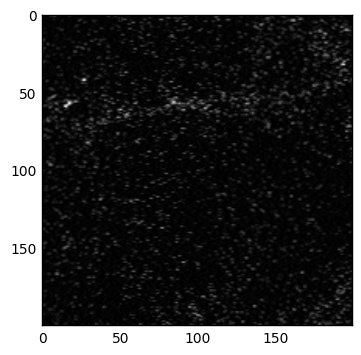

<type 'numpy.ndarray'>


In [518]:
plt.imshow(data[15, 500:700, 100:300], cmap='gray')
plt.show()
print type(magic)